In [1]:
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex import amp
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
DEVICE = torch.device('cuda')
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
    print('  allocated:', round(torch.cuda.memory_allocated(i) / 1024 ** 3, 1), 'GB')
    print('  cached:   ', round(torch.cuda.memory_cached(i) / 1024 ** 3, 1), 'GB')

0 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB
1 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB


In [2]:
MAIN_PATH = '.'
DATA_PATH = '{}/data'.format(MAIN_PATH)
LABELS_PATH = '{}/train.csv'.format(DATA_PATH)
DEBUG = False
APEX = True
M_PARAMS = {
    'MODEL_VER': 'v23',
    'TILES_DIR': '{}/train_images_tiles_q1_256_36/'.format(DATA_PATH),
    'ENET_TYPE': 'efficientnet-b0',
    'N_FOLDS': 5,
    'TILE_SIZE': 256,
    'N_TILES': 25,
    'BATCH_SIZE': 8,
    'N_WORKERS': 12,
    'OUT_DIM': 5,
    'LR': 3e-4,
    'N_EPOCHS': 10 if DEBUG else 30,
    'WARMUP': True,
    'SEED': 1000,
    'DROPOUT': .4,
    'RAND': False,
    'COMMENTS': 'only affine effnet_'
}
print(M_PARAMS)
MODELS_PATH = '{}/effnet_models_{}'.format(MAIN_PATH, M_PARAMS['MODEL_VER'])
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)
    print('created:', MODELS_PATH)
PRETRAINED_MODEL = {
    'efficientnet-b0': './bbs/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': './bbs/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': './bbs/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': './bbs/efficientnet-b3-5fb5a3c3.pth'
}

{'MODEL_VER': 'v23', 'TILES_DIR': './data/train_images_tiles_q1_256_36/', 'ENET_TYPE': 'efficientnet-b0', 'N_FOLDS': 5, 'TILE_SIZE': 256, 'N_TILES': 25, 'BATCH_SIZE': 8, 'N_WORKERS': 12, 'OUT_DIM': 5, 'LR': 0.0003, 'N_EPOCHS': 30, 'WARMUP': True, 'SEED': 1000, 'DROPOUT': 0.4, 'RAND': False, 'COMMENTS': 'only affine effnet_'}


In [3]:
if DEBUG:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv')).sample(100).reset_index(drop=True)
else:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv'))
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
skf = StratifiedKFold(M_PARAMS['N_FOLDS'], shuffle=True, random_state=M_PARAMS['SEED'])
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,2
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [5]:
class EffNet(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        #self.enet = enet.EfficientNet.from_pretrained(backbone)
        nc = self.enet._fc.in_features
        self.myfc = nn.Linear(nc, out_dim)
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
    def forward(self, x):
        x = self.enet(x)
        x = self.myfc(x)
        return x
class EffNet_(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet_, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        nc = self.enet._fc.in_features
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
        self.myfc = nn.DataParallel(
            nn.Sequential(
            nn.Linear(nc, int(nc / 4)),
            nn.ELU(),
            #nn.BatchNorm1d(int(nc / 4)), 
            nn.Dropout(M_PARAMS['DROPOUT']),
            nn.Linear(int(nc / 4), out_dim)
            )
        )
    def extract(self, x):
        return self.enet(x)
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
class ResNext(nn.Module):
    def __init__(self, out_dim):
        super(ResNext, self).__init__()
        self.rsnxt = torchvision.models.resnext50_32x4d(pretrained=True)
        nc = self.rsnxt.fc.in_features
        self.rsnxt.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nc, int(nc / 4)),
            nn.ReLU(),
            nn.BatchNorm1d(int(nc / 4)), 
            nn.Dropout(.4),
            nn.Linear(int(nc / 4), out_dim)
        )
        self.rsnxt = nn.DataParallel(self.rsnxt)
    def forward(self, x):
        x = self.rsnxt(x)
        return x

In [6]:
def get_tiles(img_id, n_tiles):
        result = []
        seq_imgs = []
        for i in range(n_tiles):
            img_path = '{}/{}_{}.png'.format(M_PARAMS['TILES_DIR'], img_id, i)
            img = cv2.imread(img_path)
            if not np.any(img):
                print('no img file read:', img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            seq_imgs.append(img)
        for i in range(len(seq_imgs)):
            result.append({'img':seq_imgs[i], 'idx':i})
        return result
class PANDADataset(Dataset):
    def __init__(self, df, tile_size, n_tiles, tile_mode=0, rand=False,
                 transform=None, transform_tile=None):
        self.df = df.reset_index(drop=True)
        self.tile_size = tile_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform
        self.transform_tile = transform_tile
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        tiles = get_tiles(img_id, self.n_tiles)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((self.tile_size * n_row_tiles, self.tile_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.tile_size, self.tile_size, 3)).astype(np.uint8) * 255
                this_img = (255 - this_img) / 255
                if self.transform_tile is not None:
                    this_img = self.transform_tile(image=this_img)['image']
                h1 = h * self.tile_size
                w1 = w * self.tile_size
                images[h1 : h1 + self.tile_size, w1:w1 + self.tile_size] = this_img
        images = images.astype(np.float32)
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.transpose(2, 0, 1)
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [7]:
transforms_train = albumentations.Compose(
    [
        #albumentations.OneOf(
        #    [
        #        albumentations.RandomBrightness(limit=.1), 
        #        albumentations.RandomContrast(limit=.1), 
        #        albumentations.RandomGamma()
        #    ], 
        #    p=.33
        #),
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5),
        albumentations.Rotate(limit=15, p=.33)
    ]
)
transforms_train_tile = albumentations.Compose(
    [
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5)
    ]
)

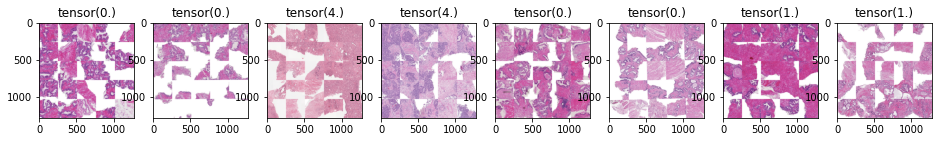

In [8]:
dataset_show = PANDADataset(
    df_train,
    M_PARAMS['TILE_SIZE'], 
    M_PARAMS['N_TILES'], 
    tile_mode=0, 
    transform=transforms_train,
    transform_tile=transforms_train_tile,
    rand=M_PARAMS['RAND']
)
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
f, axarr = plt.subplots(1, M_PARAMS['BATCH_SIZE'])
for i in range(M_PARAMS['BATCH_SIZE']):
    img, label = dataset_show.__getitem__(i)
    axarr[i].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
    axarr[i].set_title(str(sum(label)))

In [9]:
criterion = nn.BCEWithLogitsLoss()
def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(DEVICE), target.to(DEVICE)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss
def val_epoch(loader, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            logits = model(data)
            loss = criterion(logits, target)
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'karolinska'], 
        df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, 
        weights='quadratic'
    )
    qwk_r = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'radboud'], 
        df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, 
        weights='quadratic'
    )
    print('QWK', qwk, 'QWK_k', qwk_k, 'QWK_r', qwk_r)
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [ ]:
pred, target = [], []
if DEBUG:
    n_folds_train = 2
else:
    n_folds_train = M_PARAMS['N_FOLDS']
start_folds_train = 0
for fold_num in range(start_folds_train, n_folds_train):
    print('-' * 20, 'fold:', fold_num, '-' * 20)
    train_idx = np.where((df_train['fold'] != fold_num))[0]
    valid_idx = np.where((df_train['fold'] == fold_num))[0]
    df_this  = df_train.loc[train_idx]
    df_valid = df_train.loc[valid_idx]
    dataset_train = PANDADataset(
        df_this, 
        M_PARAMS['TILE_SIZE'], 
        M_PARAMS['N_TILES'], 
        transform=transforms_train,
        transform_tile=transforms_train_tile,
        rand=M_PARAMS['RAND']
    )
    dataset_valid = PANDADataset(
        df_valid, 
        M_PARAMS['TILE_SIZE'], 
        M_PARAMS['N_TILES']
    )
    train_loader = torch.utils.data.DataLoader(
        dataset_train, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=RandomSampler(dataset_train), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=SequentialSampler(dataset_valid), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    model = EffNet_(M_PARAMS['ENET_TYPE'], out_dim=M_PARAMS['OUT_DIM']) 
    #model = ResNext(out_dim=M_PARAMS['OUT_DIM'])
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=M_PARAMS['LR'])
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    if M_PARAMS['WARMUP']:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=M_PARAMS['LR'], 
            total_steps=M_PARAMS['N_EPOCHS'],
            div_factor=(M_PARAMS['LR'] / 1e-5), 
            final_div_factor=1000,
            pct_start=(2 / M_PARAMS['N_EPOCHS']),
        )
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, M_PARAMS['N_EPOCHS'])
    print('train len:', len(dataset_train),'| val len:', len(dataset_valid))
    qwk_max = 0
    best_file = '{}/{}_best_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num)
    for epoch in tqdm(range(M_PARAMS['N_EPOCHS']), desc='epochs'):
        print(time.ctime(), 'epoch:', epoch)
        train_loss = train_epoch(train_loader, optimizer)
        val_loss, acc, qwk = val_epoch(valid_loader)
        scheduler.step(epoch)
        content = '{} epoch {}, lr: {:.8f}, train loss: {:.4f}, val loss: {:.4f}, acc: {:.1f}, QWK: {:.4f}'.format(
                time.ctime(),
                epoch, 
                optimizer.param_groups[0]['lr'], 
                np.mean(train_loss),
                np.mean(val_loss),
                acc,
                qwk
            )
        print(content)
        with open('{}/log_{}_fold{}.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num), 'a') as appender:
            appender.write(content + '\n')
        if qwk > qwk_max:
            torch.save(model.state_dict(), best_file)
            print('QWK improved {:.6f} --> {:.6f} model saved'.format(qwk_max, qwk))
            qwk_max = qwk
    with open('{}/log_{}_folds_all.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE']), 'a') as appender:
        appender.write('{} | fold: {} | max QWK: {:.6f}\n'.format(M_PARAMS, fold_num, qwk_max))
    torch.save(
        model.state_dict(), 
        os.path.join('{}/{}_final_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num))
    )
    del model, dataset_train, dataset_valid, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

-------------------- fold: 0 --------------------
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
train len: 8412 | val len: 2104


Fri Jul 17 23:19:47 2020 epoch: 0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




QWK 0.6047995389210257 QWK_k 0.5323486073245955 QWK_r 0.5038992987299777
Fri Jul 17 23:33:50 2020 epoch 0, lr: 0.00001000, train loss: 0.5058, val loss: 0.3775, acc: 30.4, QWK: 0.6048
QWK improved 0.000000 --> 0.604800 model saved
Fri Jul 17 23:33:50 2020 epoch: 1



QWK 0.6977220520827722 QWK_k 0.6368291618781226 QWK_r 0.6306225637121119
Fri Jul 17 23:47:49 2020 epoch 1, lr: 0.00030000, train loss: 0.4178, val loss: 0.3319, acc: 40.3, QWK: 0.6977
QWK improved 0.604800 --> 0.697722 model saved
Fri Jul 17 23:47:49 2020 epoch: 2


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8050458947997715 QWK_k 0.7751661690489238 QWK_r 0.7559639915097495
Sat Jul 18 00:01:48 2020 epoch 2, lr: 0.00029906, train loss: 0.3739, val loss: 0.3018, acc: 55.3, QWK: 0.8050
QWK improved 0.697722 --> 0.805046 model saved
Sat Jul 18 00:01:48 2020 epoch: 3



QWK 0.7802026277137252 QWK_k 0.8055803255646269 QWK_r 0.6821815450173009
Sat Jul 18 00:15:47 2020 epoch 3, lr: 0.00029624, train loss: 0.3097, val loss: 0.2797, acc: 50.6, QWK: 0.7802
Sat Jul 18 00:15:47 2020 epoch: 4


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8437387940366821 QWK_k 0.8637385372524036 QWK_r 0.7737960390383314
Sat Jul 18 00:29:46 2020 epoch 4, lr: 0.00029158, train loss: 0.2796, val loss: 0.2344, acc: 60.7, QWK: 0.8437
QWK improved 0.805046 --> 0.843739 model saved
Sat Jul 18 00:29:46 2020 epoch: 5



QWK 0.8554303996198975 QWK_k 0.8806947665860296 QWK_r 0.7875036309322847
Sat Jul 18 00:43:45 2020 epoch 5, lr: 0.00028515, train loss: 0.2664, val loss: 0.2352, acc: 59.5, QWK: 0.8554
QWK improved 0.843739 --> 0.855430 model saved
Sat Jul 18 00:43:45 2020 epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.7821606923797657 QWK_k 0.8144875533476804 QWK_r 0.7121064496212439
Sat Jul 18 00:57:44 2020 epoch 6, lr: 0.00027701, train loss: 0.2520, val loss: 0.3102, acc: 58.9, QWK: 0.7822
Sat Jul 18 00:57:44 2020 epoch: 7



QWK 0.8615215136976179 QWK_k 0.8728856524319073 QWK_r 0.8102304163485567
Sat Jul 18 01:11:44 2020 epoch 7, lr: 0.00026728, train loss: 0.2397, val loss: 0.2321, acc: 63.8, QWK: 0.8615
QWK improved 0.855430 --> 0.861522 model saved
Sat Jul 18 01:11:44 2020 epoch: 8


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8730924420105597 QWK_k 0.8880752644431124 QWK_r 0.817032245818804
Sat Jul 18 01:25:43 2020 epoch 8, lr: 0.00025607, train loss: 0.2305, val loss: 0.2124, acc: 62.4, QWK: 0.8731
QWK improved 0.861522 --> 0.873092 model saved
Sat Jul 18 01:25:43 2020 epoch: 9



QWK 0.8717924677241108 QWK_k 0.8875583063863369 QWK_r 0.8190084639120168
Sat Jul 18 01:39:42 2020 epoch 9, lr: 0.00024353, train loss: 0.2220, val loss: 0.2104, acc: 61.2, QWK: 0.8718
Sat Jul 18 01:39:42 2020 epoch: 10


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8663620791941924 QWK_k 0.8912189849762667 QWK_r 0.8087450188886514
Sat Jul 18 01:53:42 2020 epoch 10, lr: 0.00022981, train loss: 0.2185, val loss: 0.2128, acc: 64.1, QWK: 0.8664
Sat Jul 18 01:53:42 2020 epoch: 11



QWK 0.831781396104352 QWK_k 0.83154752503944 QWK_r 0.7809981739654656
Sat Jul 18 02:07:41 2020 epoch 11, lr: 0.00021509, train loss: 0.2085, val loss: 0.2633, acc: 55.1, QWK: 0.8318
Sat Jul 18 02:07:41 2020 epoch: 12



QWK 0.8648696104091986 QWK_k 0.8792889494621112 QWK_r 0.8115511736435288
Sat Jul 18 02:21:41 2020 epoch 12, lr: 0.00019955, train loss: 0.2005, val loss: 0.2152, acc: 66.9, QWK: 0.8649
Sat Jul 18 02:21:41 2020 epoch: 13


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8564599247002618 QWK_k 0.848259887386333 QWK_r 0.8170643982166905
Sat Jul 18 02:35:41 2020 epoch 13, lr: 0.00018338, train loss: 0.1927, val loss: 0.2260, acc: 67.4, QWK: 0.8565
Sat Jul 18 02:35:41 2020 epoch: 14



QWK 0.8813659658470208 QWK_k 0.8857577026471825 QWK_r 0.8423271658539844
Sat Jul 18 02:49:40 2020 epoch 14, lr: 0.00016680, train loss: 0.1861, val loss: 0.2102, acc: 67.6, QWK: 0.8814
QWK improved 0.873092 --> 0.881366 model saved
Sat Jul 18 02:49:40 2020 epoch: 15


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8360088407537246 QWK_k 0.8710392517867609 QWK_r 0.7398111264462235
Sat Jul 18 03:03:41 2020 epoch 15, lr: 0.00015000, train loss: 0.1737, val loss: 0.2310, acc: 62.5, QWK: 0.8360
Sat Jul 18 03:03:41 2020 epoch: 16



QWK 0.8868230397849526 QWK_k 0.9055783750617831 QWK_r 0.8392351953413344
Sat Jul 18 03:17:41 2020 epoch 16, lr: 0.00013321, train loss: 0.1704, val loss: 0.1948, acc: 68.9, QWK: 0.8868
QWK improved 0.881366 --> 0.886823 model saved
Sat Jul 18 03:17:41 2020 epoch: 17



QWK 0.8895218815885806 QWK_k 0.9006188281112752 QWK_r 0.8478786971053793
Sat Jul 18 03:31:41 2020 epoch 17, lr: 0.00011663, train loss: 0.1607, val loss: 0.1984, acc: 69.1, QWK: 0.8895
QWK improved 0.886823 --> 0.889522 model saved
Sat Jul 18 03:31:41 2020 epoch: 18



QWK 0.8700242569429621 QWK_k 0.8791612118845998 QWK_r 0.8246039320055073
Sat Jul 18 03:45:40 2020 epoch 18, lr: 0.00010046, train loss: 0.1545, val loss: 0.2127, acc: 66.2, QWK: 0.8700
Sat Jul 18 03:45:40 2020 epoch: 19


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8815754810987105 QWK_k 0.8837805816266794 QWK_r 0.8467036146754098
Sat Jul 18 03:59:40 2020 epoch 19, lr: 0.00008492, train loss: 0.1479, val loss: 0.2046, acc: 68.6, QWK: 0.8816
Sat Jul 18 03:59:40 2020 epoch: 20



QWK 0.8893953722681142 QWK_k 0.897802023543999 QWK_r 0.8508317334827786
Sat Jul 18 04:13:40 2020 epoch 20, lr: 0.00007020, train loss: 0.1387, val loss: 0.2081, acc: 70.2, QWK: 0.8894
Sat Jul 18 04:13:40 2020 epoch: 21


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8858866886781049 QWK_k 0.8969838227683133 QWK_r 0.8417315215792436
Sat Jul 18 04:27:39 2020 epoch 21, lr: 0.00005648, train loss: 0.1317, val loss: 0.2105, acc: 69.3, QWK: 0.8859
Sat Jul 18 04:27:39 2020 epoch: 22



QWK 0.8819120067295512 QWK_k 0.892616920489755 QWK_r 0.83940560309994
Sat Jul 18 04:41:38 2020 epoch 22, lr: 0.00004394, train loss: 0.1276, val loss: 0.2214, acc: 69.7, QWK: 0.8819
Sat Jul 18 04:41:38 2020 epoch: 23



QWK 0.8859111162200161 QWK_k 0.8946095537533577 QWK_r 0.8440093970242757
Sat Jul 18 04:55:38 2020 epoch 23, lr: 0.00003273, train loss: 0.1228, val loss: 0.2128, acc: 69.7, QWK: 0.8859
Sat Jul 18 04:55:38 2020 epoch: 24


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.889718031440177 QWK_k 0.8987501638550816 QWK_r 0.8506942397713714
Sat Jul 18 05:09:37 2020 epoch 24, lr: 0.00002300, train loss: 0.1175, val loss: 0.2081, acc: 71.4, QWK: 0.8897
QWK improved 0.889522 --> 0.889718 model saved
Sat Jul 18 05:09:37 2020 epoch: 25



QWK 0.8869877018836031 QWK_k 0.8963327673740741 QWK_r 0.8478576213955602
Sat Jul 18 05:23:36 2020 epoch 25, lr: 0.00001486, train loss: 0.1120, val loss: 0.2151, acc: 71.4, QWK: 0.8870
Sat Jul 18 05:23:36 2020 epoch: 26


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8896815977154413 QWK_k 0.8989139705560106 QWK_r 0.8503170445127167
Sat Jul 18 05:37:35 2020 epoch 26, lr: 0.00000843, train loss: 0.1096, val loss: 0.2141, acc: 71.2, QWK: 0.8897
Sat Jul 18 05:37:35 2020 epoch: 27



QWK 0.8899369433978063 QWK_k 0.8980554466923327 QWK_r 0.851522353096374
Sat Jul 18 05:51:35 2020 epoch 27, lr: 0.00000377, train loss: 0.1116, val loss: 0.2102, acc: 70.8, QWK: 0.8899
QWK improved 0.889718 --> 0.889937 model saved
Sat Jul 18 05:51:35 2020 epoch: 28


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8879719086227013 QWK_k 0.8952998055331282 QWK_r 0.8501538099480577
Sat Jul 18 06:05:34 2020 epoch 28, lr: 0.00000095, train loss: 0.1052, val loss: 0.2110, acc: 71.4, QWK: 0.8880
Sat Jul 18 06:05:34 2020 epoch: 29


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0




QWK 0.8906947121652418 QWK_k 0.9002433810077782 QWK_r 0.8517965548501647
Sat Jul 18 06:19:33 2020 epoch 29, lr: 0.00000001, train loss: 0.1064, val loss: 0.2104, acc: 71.1, QWK: 0.8907
QWK improved 0.889937 --> 0.890695 model saved

-------------------- fold: 1 --------------------
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
train len: 8413 | val len: 21

Sat Jul 18 06:19:34 2020 epoch: 0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




QWK 0.5658628541507434 QWK_k 0.509144321652876 QWK_r 0.47923308935424436
Sat Jul 18 06:33:38 2020 epoch 0, lr: 0.00001000, train loss: 0.5106, val loss: 0.4045, acc: 26.6, QWK: 0.5659
QWK improved 0.000000 --> 0.565863 model saved
Sat Jul 18 06:33:38 2020 epoch: 1



QWK 0.6959393162830605 QWK_k 0.666972214738359 QWK_r 0.6440880726825956
Sat Jul 18 06:47:43 2020 epoch 1, lr: 0.00030000, train loss: 0.4181, val loss: 0.3377, acc: 38.1, QWK: 0.6959
QWK improved 0.565863 --> 0.695939 model saved
Sat Jul 18 06:47:43 2020 epoch: 2


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8115961523593807 QWK_k 0.8047843802137686 QWK_r 0.763287456237405
Sat Jul 18 07:01:47 2020 epoch 2, lr: 0.00029906, train loss: 0.3707, val loss: 0.2678, acc: 53.1, QWK: 0.8116
QWK improved 0.695939 --> 0.811596 model saved
Sat Jul 18 07:01:47 2020 epoch: 3



QWK 0.802353905156864 QWK_k 0.8108703334605545 QWK_r 0.7466215154286748
Sat Jul 18 07:15:52 2020 epoch 3, lr: 0.00029624, train loss: 0.3060, val loss: 0.2627, acc: 50.2, QWK: 0.8024
Sat Jul 18 07:15:52 2020 epoch: 4



QWK 0.8390385034078851 QWK_k 0.8275307100044014 QWK_r 0.8066651104672717
Sat Jul 18 07:29:56 2020 epoch 4, lr: 0.00029158, train loss: 0.2772, val loss: 0.2469, acc: 60.1, QWK: 0.8390
QWK improved 0.811596 --> 0.839039 model saved
Sat Jul 18 07:29:56 2020 epoch: 5



QWK 0.8271828526128189 QWK_k 0.8325496982231039 QWK_r 0.7853403368828991
Sat Jul 18 07:44:01 2020 epoch 5, lr: 0.00028515, train loss: 0.2586, val loss: 0.2662, acc: 59.5, QWK: 0.8272
Sat Jul 18 07:44:01 2020 epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8290604420588483 QWK_k 0.8382248210202781 QWK_r 0.7799577704280882
Sat Jul 18 07:58:05 2020 epoch 6, lr: 0.00027701, train loss: 0.2477, val loss: 0.2603, acc: 53.8, QWK: 0.8291
Sat Jul 18 07:58:05 2020 epoch: 7



QWK 0.841768614245631 QWK_k 0.8343035492214126 QWK_r 0.8087798274864844
Sat Jul 18 08:12:10 2020 epoch 7, lr: 0.00026728, train loss: 0.2395, val loss: 0.2489, acc: 59.5, QWK: 0.8418
QWK improved 0.839039 --> 0.841769 model saved
Sat Jul 18 08:12:10 2020 epoch: 8


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8549334395862311 QWK_k 0.859775791748541 QWK_r 0.8187537673535954
Sat Jul 18 08:26:14 2020 epoch 8, lr: 0.00025607, train loss: 0.2300, val loss: 0.2321, acc: 63.6, QWK: 0.8549
QWK improved 0.841769 --> 0.854933 model saved
Sat Jul 18 08:26:14 2020 epoch: 9



QWK 0.8505925687188506 QWK_k 0.8600465346853039 QWK_r 0.8039536404975012
Sat Jul 18 08:40:19 2020 epoch 9, lr: 0.00024353, train loss: 0.2196, val loss: 0.2436, acc: 62.2, QWK: 0.8506
Sat Jul 18 08:40:19 2020 epoch: 10



QWK 0.8337629588861948 QWK_k 0.8423832836744295 QWK_r 0.7830656688808543
Sat Jul 18 08:54:24 2020 epoch 10, lr: 0.00022981, train loss: 0.2106, val loss: 0.2577, acc: 59.0, QWK: 0.8338
Sat Jul 18 08:54:24 2020 epoch: 11


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8701548562562527 QWK_k 0.8806868372939498 QWK_r 0.8339460870207938
Sat Jul 18 09:08:29 2020 epoch 11, lr: 0.00021509, train loss: 0.1990, val loss: 0.2217, acc: 64.6, QWK: 0.8702
QWK improved 0.854933 --> 0.870155 model saved
Sat Jul 18 09:08:29 2020 epoch: 12



QWK 0.8516254635567471 QWK_k 0.8718817989254923 QWK_r 0.8073937504654154
Sat Jul 18 09:22:33 2020 epoch 12, lr: 0.00019955, train loss: 0.1959, val loss: 0.2372, acc: 64.0, QWK: 0.8516
Sat Jul 18 09:22:33 2020 epoch: 13



QWK 0.8599729688741626 QWK_k 0.8841692194390409 QWK_r 0.8088942039858276
Sat Jul 18 09:36:38 2020 epoch 13, lr: 0.00018338, train loss: 0.1857, val loss: 0.2447, acc: 65.2, QWK: 0.8600
Sat Jul 18 09:36:38 2020 epoch: 14


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8406925504561036 QWK_k 0.8471801967219457 QWK_r 0.800413545303549
Sat Jul 18 09:50:44 2020 epoch 14, lr: 0.00016680, train loss: 0.1780, val loss: 0.2403, acc: 62.0, QWK: 0.8407
Sat Jul 18 09:50:44 2020 epoch: 15



QWK 0.8565096182693994 QWK_k 0.8751184391553805 QWK_r 0.8133582536409621
Sat Jul 18 10:04:49 2020 epoch 15, lr: 0.00015000, train loss: 0.1729, val loss: 0.2342, acc: 65.4, QWK: 0.8565
Sat Jul 18 10:04:49 2020 epoch: 16


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8591086430411311 QWK_k 0.8729987310440578 QWK_r 0.8194395819224921
Sat Jul 18 10:18:53 2020 epoch 16, lr: 0.00013321, train loss: 0.1649, val loss: 0.2435, acc: 66.2, QWK: 0.8591
Sat Jul 18 10:18:53 2020 epoch: 17


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8591224492129242 QWK_k 0.8751115996714105 QWK_r 0.8131531547541225
Sat Jul 18 10:32:58 2020 epoch 17, lr: 0.00011663, train loss: 0.1563, val loss: 0.2373, acc: 65.2, QWK: 0.8591
Sat Jul 18 10:32:58 2020 epoch: 18



QWK 0.860164231823023 QWK_k 0.8837313580700397 QWK_r 0.815623919594915
Sat Jul 18 10:47:03 2020 epoch 18, lr: 0.00010046, train loss: 0.1472, val loss: 0.2470, acc: 68.0, QWK: 0.8602
Sat Jul 18 10:47:03 2020 epoch: 19



QWK 0.85797433987722 QWK_k 0.8776389523778638 QWK_r 0.813559943507611
Sat Jul 18 11:01:08 2020 epoch 19, lr: 0.00008492, train loss: 0.1451, val loss: 0.2388, acc: 65.2, QWK: 0.8580
Sat Jul 18 11:01:08 2020 epoch: 20



QWK 0.857422324590004 QWK_k 0.8779106159238858 QWK_r 0.8107659091740769
Sat Jul 18 11:15:14 2020 epoch 20, lr: 0.00007020, train loss: 0.1385, val loss: 0.2451, acc: 64.4, QWK: 0.8574
Sat Jul 18 11:15:14 2020 epoch: 21


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.863733079510024 QWK_k 0.8818159061154607 QWK_r 0.8256101498476142
Sat Jul 18 11:29:17 2020 epoch 21, lr: 0.00005648, train loss: 0.1272, val loss: 0.2406, acc: 68.0, QWK: 0.8637
Sat Jul 18 11:29:17 2020 epoch: 22



QWK 0.8683705248556363 QWK_k 0.8825450753074544 QWK_r 0.8317589919941013
Sat Jul 18 11:43:21 2020 epoch 22, lr: 0.00004394, train loss: 0.1216, val loss: 0.2386, acc: 68.2, QWK: 0.8684
Sat Jul 18 11:43:21 2020 epoch: 23


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8714609674340803 QWK_k 0.8867959901673274 QWK_r 0.8345170257542044
Sat Jul 18 11:57:24 2020 epoch 23, lr: 0.00003273, train loss: 0.1188, val loss: 0.2531, acc: 68.6, QWK: 0.8715
QWK improved 0.870155 --> 0.871461 model saved
Sat Jul 18 11:57:24 2020 epoch: 24



QWK 0.8702725533925411 QWK_k 0.8798080096638766 QWK_r 0.8372232955137768
Sat Jul 18 12:11:27 2020 epoch 24, lr: 0.00002300, train loss: 0.1119, val loss: 0.2462, acc: 69.3, QWK: 0.8703
Sat Jul 18 12:11:27 2020 epoch: 25



QWK 0.8680997730099529 QWK_k 0.8810774299089442 QWK_r 0.8327051179957782
Sat Jul 18 12:25:31 2020 epoch 25, lr: 0.00001486, train loss: 0.1096, val loss: 0.2475, acc: 68.1, QWK: 0.8681
Sat Jul 18 12:25:31 2020 epoch: 26



QWK 0.8717813972949497 QWK_k 0.8835205781325101 QWK_r 0.8380096558111048
Sat Jul 18 12:39:34 2020 epoch 26, lr: 0.00000843, train loss: 0.1085, val loss: 0.2483, acc: 69.7, QWK: 0.8718
QWK improved 0.871461 --> 0.871781 model saved
Sat Jul 18 12:39:34 2020 epoch: 27


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8703353818628496 QWK_k 0.8821428534557074 QWK_r 0.8360396810006747
Sat Jul 18 12:53:37 2020 epoch 27, lr: 0.00000377, train loss: 0.1048, val loss: 0.2523, acc: 69.3, QWK: 0.8703
Sat Jul 18 12:53:37 2020 epoch: 28



QWK 0.8687085617250808 QWK_k 0.8803633314977428 QWK_r 0.8340908670876328
Sat Jul 18 13:07:40 2020 epoch 28, lr: 0.00000095, train loss: 0.1047, val loss: 0.2513, acc: 69.6, QWK: 0.8687
Sat Jul 18 13:07:40 2020 epoch: 29


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8687503700381909 QWK_k 0.8811020263313292 QWK_r 0.8336262563459853
Sat Jul 18 13:21:44 2020 epoch 29, lr: 0.00000001, train loss: 0.1024, val loss: 0.2495, acc: 69.1, QWK: 0.8688

-------------------- fold: 2 --------------------
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
train len: 8413 | val len: 2103


Sat Jul 18 13:21:44 2020 epoch: 0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




QWK 0.5686173245037511 QWK_k 0.4921307597947654 QWK_r 0.49686715947976734
Sat Jul 18 13:35:51 2020 epoch 0, lr: 0.00001000, train loss: 0.5029, val loss: 0.3997, acc: 25.7, QWK: 0.5686
QWK improved 0.000000 --> 0.568617 model saved
Sat Jul 18 13:35:51 2020 epoch: 1



QWK 0.6857798466334744 QWK_k 0.6423404072948022 QWK_r 0.6124548104754477
Sat Jul 18 13:49:57 2020 epoch 1, lr: 0.00030000, train loss: 0.4228, val loss: 0.3498, acc: 38.9, QWK: 0.6858
QWK improved 0.568617 --> 0.685780 model saved
Sat Jul 18 13:49:57 2020 epoch: 2


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.7785390881385236 QWK_k 0.7878910451250877 QWK_r 0.724462521362097
Sat Jul 18 14:04:04 2020 epoch 2, lr: 0.00029906, train loss: 0.3680, val loss: 0.2924, acc: 54.2, QWK: 0.7785
QWK improved 0.685780 --> 0.778539 model saved
Sat Jul 18 14:04:04 2020 epoch: 3



QWK 0.8079514031048076 QWK_k 0.8164473258589975 QWK_r 0.7529129498798514
Sat Jul 18 14:18:10 2020 epoch 3, lr: 0.00029624, train loss: 0.3001, val loss: 0.2636, acc: 58.0, QWK: 0.8080
QWK improved 0.778539 --> 0.807951 model saved
Sat Jul 18 14:18:10 2020 epoch: 4


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8246489731062813 QWK_k 0.8237449102916112 QWK_r 0.7739262186015031
Sat Jul 18 14:32:17 2020 epoch 4, lr: 0.00029158, train loss: 0.2742, val loss: 0.2686, acc: 61.2, QWK: 0.8246
QWK improved 0.807951 --> 0.824649 model saved
Sat Jul 18 14:32:17 2020 epoch: 5



QWK 0.8371216395365623 QWK_k 0.8478302177054002 QWK_r 0.7873173620860756
Sat Jul 18 14:46:24 2020 epoch 5, lr: 0.00028515, train loss: 0.2615, val loss: 0.2762, acc: 58.3, QWK: 0.8371
QWK improved 0.824649 --> 0.837122 model saved
Sat Jul 18 14:46:24 2020 epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




QWK 0.8523957270336716 QWK_k 0.8512726181187258 QWK_r 0.8090063881442026
Sat Jul 18 15:00:31 2020 epoch 6, lr: 0.00027701, train loss: 0.2465, val loss: 0.2260, acc: 61.2, QWK: 0.8524
QWK improved 0.837122 --> 0.852396 model saved
Sat Jul 18 15:00:31 2020 epoch: 7


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8386956651237525 QWK_k 0.8413245239436152 QWK_r 0.7935647497469833
Sat Jul 18 15:14:38 2020 epoch 7, lr: 0.00026728, train loss: 0.2330, val loss: 0.2334, acc: 62.7, QWK: 0.8387
Sat Jul 18 15:14:38 2020 epoch: 8



QWK 0.8479237884714009 QWK_k 0.8590012500091853 QWK_r 0.8029835436289552
Sat Jul 18 15:28:44 2020 epoch 8, lr: 0.00025607, train loss: 0.2265, val loss: 0.2371, acc: 63.0, QWK: 0.8479
Sat Jul 18 15:28:44 2020 epoch: 9



QWK 0.8538324730222997 QWK_k 0.8673262330723902 QWK_r 0.8042010041199452
Sat Jul 18 15:42:52 2020 epoch 9, lr: 0.00024353, train loss: 0.2181, val loss: 0.2216, acc: 61.3, QWK: 0.8538
QWK improved 0.852396 --> 0.853832 model saved
Sat Jul 18 15:42:52 2020 epoch: 10


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8242871597116076 QWK_k 0.8260445849457677 QWK_r 0.7791291848724244
Sat Jul 18 15:56:58 2020 epoch 10, lr: 0.00022981, train loss: 0.2100, val loss: 0.2679, acc: 63.5, QWK: 0.8243
Sat Jul 18 15:56:58 2020 epoch: 11



QWK 0.8562454410707286 QWK_k 0.8652453961547929 QWK_r 0.8122919585509866
Sat Jul 18 16:11:04 2020 epoch 11, lr: 0.00021509, train loss: 0.2039, val loss: 0.2347, acc: 65.7, QWK: 0.8562
QWK improved 0.853832 --> 0.856245 model saved
Sat Jul 18 16:11:04 2020 epoch: 12



QWK 0.8480572090297616 QWK_k 0.8490394044445673 QWK_r 0.8088205083809448
Sat Jul 18 16:25:11 2020 epoch 12, lr: 0.00019955, train loss: 0.1965, val loss: 0.2292, acc: 65.7, QWK: 0.8481
Sat Jul 18 16:25:11 2020 epoch: 13


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




QWK 0.8533862574485885 QWK_k 0.8767853379332008 QWK_r 0.8048548480779483
Sat Jul 18 16:39:18 2020 epoch 13, lr: 0.00018338, train loss: 0.1857, val loss: 0.2409, acc: 66.0, QWK: 0.8534
Sat Jul 18 16:39:18 2020 epoch: 14
